# Plot variation with pH

- uses data/analysis_yield_expt_summary.xlsx
- plot excretion/yields vs pH

In [4]:
import sys, os
import glob 
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import collections
import builtins

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from scipy.integrate import odeint #this is the module to solve ODEs
#import met_brewer
%matplotlib inline
import scipy.stats 
import json

import csv
from collections import defaultdict
from pprint import pprint

sublistshort=['glu','mal','ace','but','for','lac','pro','suc']
#colorlist = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
#print(colorlist)
sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate'] #skipp ethanol here
#colorlist=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']
colorlist=['#5d5d5d','#BBBBBB','#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']

#tol bright https://personal.sron.nl/~pault/#sec:qualitative

markerlist=['s','v','^','<','>','d','o','h']
energycontent=np.array([0.68,1.36,0.21,0.52,0.,.33,0.37,0.36]) #kcal/mmol #the energy per mm for different fermentation products3
cfactorlist=[6,12,2,4,1,3,3,4]

################################
#load information of species to include
#################################
#load species information for all characterized species
speciesinformation=pd.read_csv("data_hplc/species_properties.csv",skiprows=1)
display(speciesinformation.head())

,species_HPLCname,species,new_species,species.1,species_short,new_genus,genus,new_family,family,new_order,order,new_class,class,new_phylum,phylum
0,B.uniformis,Bacteroides uniformis,Bacteroides uniformis,Bacteroides uniformis,B. uniformis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
1,B.fragilis,Bacteroides fragilis,Bacteroides fragilis,Bacteroides fragilis,B. fragilis,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
2,B.ovatus,Bacteroides ovatus,Bacteroides ovatus,Bacteroides ovatus,B. ovatus,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
3,B.theta,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,Bacteroides thetaiotaomicron,B. theta,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes
4,B.finegoldii,Bacteroides finegoldii,Bacteroides finegoldii,Bacteroides finegoldii,B. finegoldii,Bacteroides,Bacteroides,Bacteroidaceae,Bacteroidaceae,Bacteroidales,Bacteroidales,Bacteroidia,Bacteroidia,Bacteroidota,Bacteroidetes


# Read in data and select only samples with pH information

This script takes data from analysis_out.csv which is generated in the final_analysis notebook. 


In [5]:
###################
#decide what to plot
####################

#use a table with average values  (to generate this table, run Final_analysis_hplcdata.ipynb
dataout_av=pd.read_csv("data_hplc/analysis_out_av_pHdata.csv")
#display(dataout_av.head())
#display(speciesinformation.head())

#sort list manually 


sorter=[]
sorter=sorter+["B.uniformis","B.fragilis","B.ovatus","B.theta","B.finegoldii"]
sorter=sorter+["B.vulgatus"]
sorter=sorter+["P.copri"]
sorter=sorter+["P.distastonis"]
sorter=sorter+["R.intestinalis","E.rectale","L.eligens","D.longicatena","F.saccharivorans","B.wexleri","B.hydrogenotrophica"]
sorter=sorter+["F.prausnitzii","E.siraeum","R.bromii"]
sorter=sorter+["B.longum","B.adolescentis"]
sorter=sorter+["C.aerofaciens"]
sorter=sorter+["E.coli","E.coliI","E.coliII","Fecal","FecalPP","ECOR"]

#double check
#sorter=["B.vulgatus","B.fragilis","B.ovatus","B.theta","B.finegoldii","B.uniformis",'P.copri','P.distastonis',"E.rectale","R.intestinalis","D.longicatena","F.saccharivorans","B.wexleri","L.eligens","B.hydrogenotrophica","F.prausnitzii","R.bromii","B.longum","B.adolescentis","C.aerofaciens","E.coli","E.coliI","E.coliII","Fecal","FecalPP","ECOR","E.halli"]
#old: sorter=["B.vulgatus","B.fragilis","B.ovatus","B.theta","B.finegoldii","B.uniformis",'P.copri','P.distastonis',"E.rectale","R.intestinalis","F.prausnitzii","R.bromii","B.longum","B.adolescentis","C.aerofaciens","E.coli","E.coliI","E.coliII","Fecal","FecalPP","ECOR","E.halli"]
dataout_av.sort_values(by="species", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)

#select to plot only averages or not



#dataout_av=dataout_av.loc[dataout_av["experiment_short"]=="av"]
select=dataout_av.loc[dataout_av["experiment_short"]!="av"]

display(select)
display(select.columns)

select=select.groupby(["pH","species"]).mean(numeric_only=True).reset_index()


#speciesall=speciesinformation["species_HPLCname"]
#speciesall=sorter[:16]

#select only samples with pH value measured
specieslist=select["species"].unique()
num_strains=len(specieslist)


display(specieslist)

display(select.columns)


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,strain,species,experiment,experiment_short,exp_number,medium,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
0,0,40.0,54.0,5.83,ATCC29148,B.theta,Markus_old_Bt6,Markus_old_Bt6,67,epsilon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,11,56.0,50.0,6.61,ATCC29148,B.theta,Markus_old_Bt2,Markus_old_Bt2,63,epsilon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,10,52.0,49.0,7.14,ATCC29148,B.theta,Markus_old_Bt1,Markus_old_Bt1,62,epsilon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12,59.0,75.0,5.67,ATCC29148,B.theta,Markus_old_Bt13,Markus_old_Bt13,88,epsilon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,50.0,51.0,6.19,ATCC29148,B.theta,Markus_old_Bt3,Markus_old_Bt3,64,epsilon,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,67,207.0,219.0,7.15,ATCC27255,R.bromii,NaN,hplc_analysis_revisions_stanford,288,pHvar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,68,208.0,220.0,7.15,ATCC27255,R.bromii,NaN,hplc_analysis_revisions_stanford,289,pHvar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,69,209.0,215.0,6.56,ATCC27255,R.bromii,NaN,hplc_analysis_revisions_stanford,283,pHvar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,70,210.0,211.0,5.97,ATCC27255,R.bromii,NaN,hplc_analysis_revisions_stanford,275,pHvar,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'notes', 'strain',
       'species', 'experiment', 'experiment_short', 'exp_number', 'medium',
       'experimentator', 'sample_number', 'growth_rate', 'use_in_study',
       'growthcurve_OD', 'growthcurve_time', 'exp_number_usedonly', 'pH',
       'num_av', 'date_of_experiment', 'glucose', 'glucose_y0', 'glucose_OD',
       'glucose_conc', 'acetate', 'acetate_y0', 'acetate_OD', 'acetate_conc',
       'propionate', 'propionate_y0', 'propionate_OD', 'propionate_conc',
       'succinate', 'succinate_y0', 'succinate_OD', 'succinate_conc',
       'lactate', 'lactate_y0', 'lactate_OD', 'lactate_conc', 'butyrate',
       'formate', 'formate_y0', 'formate_OD', 'formate_conc', 'maltose',
       'maltose_y0', 'maltose_OD', 'maltose_conc', 'butyrate_y0',
       'butyrate_OD', 'butyrate_conc', 'glucose_std', 'acetate_std',
       'propionate_std', 'succinate_std', 'lactate_std', 'butyrate_std',
       'formate_std', 'maltose_std', 'total_ferm',

array(['P.copri', 'R.bromii', 'B.vulgatus', 'F.prausnitzii', 'B.theta',
       'E.rectale'], dtype=object)

Index(['pH', 'species', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'notes',
       'sample_number', 'growth_rate', 'exp_number_usedonly', 'num_av',
       'date_of_experiment', 'glucose', 'glucose_y0', 'acetate', 'acetate_y0',
       'propionate', 'propionate_y0', 'succinate', 'succinate_y0', 'lactate',
       'lactate_y0', 'butyrate', 'formate', 'formate_y0', 'maltose',
       'maltose_y0', 'butyrate_y0', 'glucose_std', 'acetate_std',
       'propionate_std', 'succinate_std', 'lactate_std', 'butyrate_std',
       'formate_std', 'maltose_std', 'total_ferm', 'total_ferm_std',
       'total_uptake', 'total_uptake_std', 'growth_rate_std'],
      dtype='object')

['P.copri' 'R.bromii' 'B.vulgatus' 'F.prausnitzii' 'B.theta' 'E.rectale']


<>:219: SyntaxWarning: invalid escape sequence '\D'
<>:220: SyntaxWarning: invalid escape sequence '\D'
<>:219: SyntaxWarning: invalid escape sequence '\D'
<>:220: SyntaxWarning: invalid escape sequence '\D'
/var/folders/kc/n6kw930x6kq64srbgvnpcrz40000gn/T/ipykernel_3568/2082970738.py:219: SyntaxWarning: invalid escape sequence '\D'
  ax4[0].set_xlabel("av. relative change $\Delta$pH$=1$")
/var/folders/kc/n6kw930x6kq64srbgvnpcrz40000gn/T/ipykernel_3568/2082970738.py:220: SyntaxWarning: invalid escape sequence '\D'
  ax4[1].set_xlabel("av. relative change $\Delta$pH$=1$")


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
2,5.55,B.vulgatus,24.333333,88.333333,197.0,5.55,NaN,0.684074,82.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,6.00,B.vulgatus,20.333333,84.333333,194.0,6.00,NaN,0.853413,78.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,6.35,B.vulgatus,18.333333,82.333333,185.0,6.35,NaN,0.743592,76.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,6.66,B.vulgatus,14.000000,78.000000,182.0,6.66,NaN,0.740968,72.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,7.00,B.vulgatus,23.000000,87.333333,179.0,7.00,NaN,0.749814,81.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
5,5.63,E.rectale,36.000000,134.000000,61.0,5.63,NaN,0.516426,127.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.64,E.rectale,28.000000,122.000000,78.0,5.64,NaN,0.460224,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.83,E.rectale,37.000000,135.000000,60.0,5.83,NaN,0.584323,128.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,5.84,E.rectale,44.000000,147.000000,77.0,5.84,NaN,0.585795,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,5.95,E.rectale,38.000000,136.000000,59.0,5.95,NaN,0.665877,129.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,5.98,E.rectale,43.000000,146.000000,76.0,5.98,NaN,0.598489,139.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,6.06,E.rectale,39.000000,138.000000,58.0,6.06,NaN,0.688031,131.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,6.12,E.rectale,29.000000,123.000000,72.0,6.12,NaN,0.664183,116.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,6.19,E.rectale,36.500000,135.000000,60.5,6.19,NaN,0.678428,128.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,6.21,E.rectale,30.000000,124.000000,71.0,6.21,NaN,0.669368,117.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


      pH    species  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes  \
5   5.63  E.rectale     36.000000    134.000000        61.0   5.63   
6   5.64  E.rectale     28.000000    122.000000        78.0   5.64   
9   5.83  E.rectale     37.000000    135.000000        60.0   5.83   
10  5.84  E.rectale     44.000000    147.000000        77.0   5.84   
13  5.95  E.rectale     38.000000    136.000000        59.0   5.95   
17  5.98  E.rectale     43.000000    146.000000        76.0   5.98   
20  6.06  E.rectale     39.000000    138.000000        58.0   6.06   
22  6.12  E.rectale     29.000000    123.000000        72.0   6.12   
24  6.19  E.rectale     36.500000    135.000000        60.5   6.19   
26  6.21  E.rectale     30.000000    124.000000        71.0   6.21   
31  6.61  E.rectale     35.333333    134.333333        63.0   6.61   
37  7.14  E.rectale     36.333333    136.000000        62.0   7.14   

    sample_number  growth_rate  exp_number_usedonly  num_av  ...  \
5             NaN    

,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
0,5.52,P.copri,61.0,188.5,205.5,5.52,NaN,0.800684,180.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,5.97,P.copri,62.5,190.5,209.5,5.97,NaN,0.623065,182.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,6.56,P.copri,61.0,188.5,213.5,6.56,NaN,2.184845,180.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,7.15,P.copri,57.5,184.5,217.5,7.15,NaN,2.211535,176.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
1,5.52,R.bromii,71.5,212.0,207.5,5.52,NaN,0.810771,204.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,5.97,R.bromii,67.5,206.5,211.5,5.97,NaN,1.278446,198.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,6.56,R.bromii,67.5,207.5,215.5,6.56,NaN,1.140492,199.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,7.15,R.bromii,67.5,207.5,219.5,7.15,NaN,1.261530,199.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
3,5.55,F.prausnitzii,50.000000,157.000000,200.0,5.55,NaN,0.481844,149.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,6.00,F.prausnitzii,53.333333,162.333333,203.0,6.00,NaN,0.486355,154.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,6.64,F.prausnitzii,51.666667,161.666667,191.0,6.64,NaN,0.205487,153.666667,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,6.97,F.prausnitzii,47.000000,154.000000,188.0,6.97,NaN,0.280648,146.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
4,5.63,B.theta,4.0,44.0,52.0,5.63,NaN,0.403379,43.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.67,B.theta,12.0,59.0,75.0,5.67,NaN,0.195580,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5.83,B.theta,0.0,40.0,54.0,5.83,NaN,0.657623,41.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,5.85,B.theta,9.0,51.0,74.0,5.85,NaN,0.567488,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,5.95,B.theta,1.0,41.0,53.0,5.95,NaN,0.833813,42.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,5.98,B.theta,7.0,48.0,73.0,5.98,NaN,0.742884,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,6.12,B.theta,6.0,46.0,68.0,6.12,NaN,0.916207,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,6.19,B.theta,8.0,50.0,51.0,6.19,NaN,0.977575,46.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,6.21,B.theta,5.0,45.0,67.0,6.21,NaN,0.961137,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,6.61,B.theta,6.5,49.0,58.0,6.61,NaN,1.025684,51.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/kc/n6kw930x6kq64srbgvnpcrz40000gn/T/ipykernel_3568/2082970738.py:202: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0,2].legend()


average ratio uptake and excre
0.9939201151819174
1.0048204083059853
-0.006079884818082637
0.004820408305985291


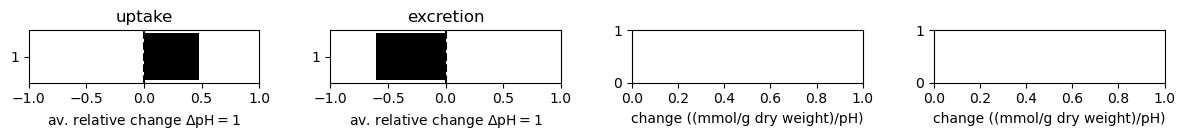

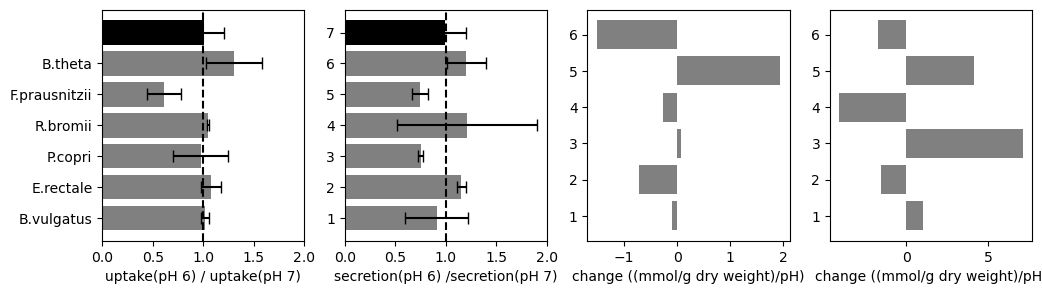

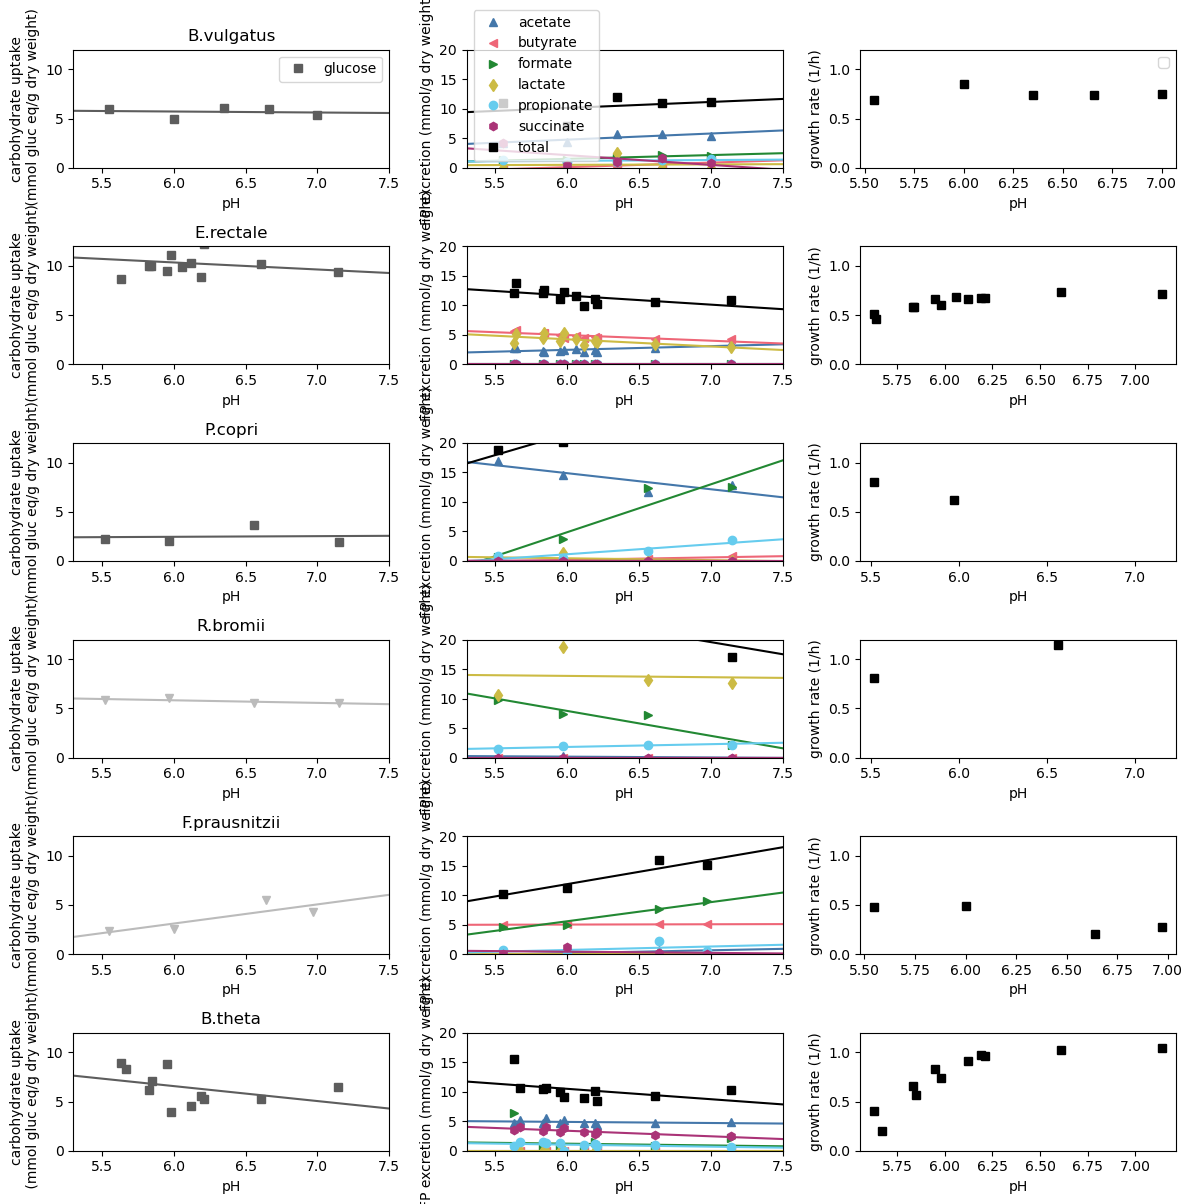

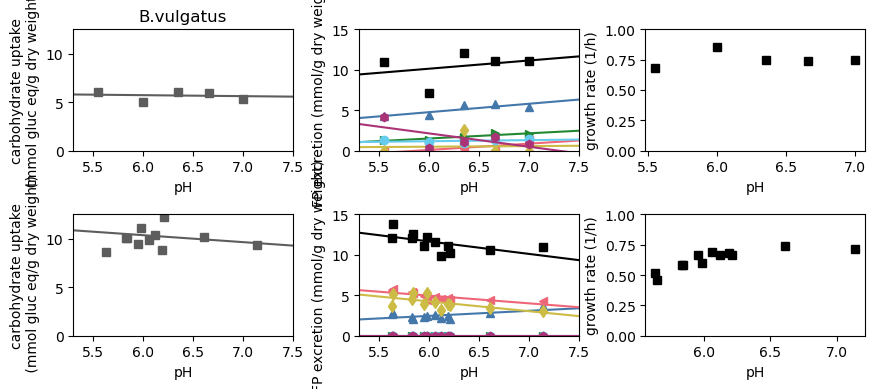

In [6]:

#figure for relativve change, av only
fig4, ax4 = plt.subplots(1,4,figsize=(4*3,1.5))  #for barplots yields/excretion



#figure for relativve change
fig2, ax2 = plt.subplots(1,4,figsize=(4*3,3))  #for barplots yields/excretion



#plot species
fig, ax = plt.subplots(num_strains,3,figsize=(4*3,2*num_strains))  #for barplots yields/excretion
x=np.linspace(5.3,7.5,10)  
ms='o'
iS=-1


#plot example pH dependence (two species only)
fig3, ax3 = plt.subplots(2,3,figsize=(3*3,2*2))  #for barplots yields/excretion



print(specieslist)
specieslist=['B.vulgatus','E.rectale','P.copri','R.bromii', 'F.prausnitzii','B.theta']
num_species=len(specieslist)

ratio_uptake=np.zeros([num_species])
ratio_excretion=np.zeros([num_species])

for species in specieslist:
    iS=iS+1
    select2=select.loc[select["species"]==species]
    display(select2)

    if species=="E.rectale":
        print(select2)

    ax[iS,0].set_title(species)
    sc=-1

    first_sec=1
    
    fit_substrates={}
    for sub in sublist:
        sc=sc+1
        ax[iS,0].set_ylim(0,12)
        ax[iS,0].set_xlim(5.3,7.5)
        ax[iS,1].set_xlim(5.3,7.5)
        
        
        if sub in ["glucose"]:
            if species in ['B.vulgatus','B.theta','P.copri','E.rectale']:
                ax[iS,0].plot(select2["pH"],-1*select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
                #totuptake = -1*select2[sub]*cfactorlist[sc]
                fit, covV =np.polyfit(select2["pH"],-1*select2[sub],1,cov=True)
                fit_substrates[sub+"_m"]=fit[0]
                fit_substrates[sub+"_y"]=fit[1]
                fit_substrates[sub+"_m_error"]=covV[0,0]
                ax[iS,0].plot(x,x*fit_substrates[sub+"_m"]+fit_substrates[sub+"_y"],color=colorlist[sc],ls='-')
                fit_substrates["uptake_y"]=fit_substrates[sub+"_y"]
                fit_substrates["uptake_m"]=fit_substrates[sub+"_m"]
                fit_substrates["uptake_m_error"]=covV[0,0]
                if species in ['B.vulgatus','E.rectale']:
                    ax3[iS,1].set_xlim(5.3,7.5)
                    ax3[iS,0].set_xlim(5.3,7.5)
                    #ax3[iS,0].set_ylim(0,8)
                    ax3[iS,0].plot(select2["pH"],-1*select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
                    ax3[iS,0].plot(x,x*fit_substrates[sub+"_m"]+fit_substrates[sub+"_y"],color=colorlist[sc],ls='-')
                    ax3[iS,0].set_ylim(0,12.5)
                
        elif sub in ["maltose"]:
            if species in ['R.bromii','F.prausnitzii']:
                ax[iS,0].plot(select2["pH"],-2*select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
                #print(select2[sub])
                #if select2[sub]<=0:
                #if select2[sub].isnull().values.any():
                #    pass
                #else:
                #totuptake= -1*select2[sub]*cfactorlist[sc]
                fit, covV =np.polyfit(select2["pH"],-2*select2[sub],1,cov=True)
                fit_substrates[sub+"_m"]=fit[0]
                fit_substrates[sub+"_y"]=fit[1]
                fit_substrates[sub+"_m_error"]=covV[0,0]
                fit_substrates["uptake_y"]=fit_substrates[sub+"_y"]
                fit_substrates["uptake_m"]=fit_substrates[sub+"_m"]
                fit_substrates["uptake_m_error"]=covV[0,0]
                ax[iS,0].plot(x,x*fit_substrates[sub+"_m"]+fit_substrates[sub+"_y"],color=colorlist[sc],ls='-')

        else:
            ax[iS,1].plot(select2["pH"],select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
            if first_sec==1:
                first_sec=0
                totalsecretion=select2[sub].values
            else:
                totalsecretion=totalsecretion+select2[sub].values
            fit, covV =np.polyfit(select2["pH"],select2[sub],1,cov=True)
            fit_substrates[sub+"_m"]=fit[0]
            fit_substrates[sub+"_y"]=fit[1]
            fit_substrates[sub+"_m_error"]=covV[0,0]
                
            if sub=="acetate":
                totfp=select2[sub]*cfactorlist[sc]
            else:
                totfp=totfp+select2[sub]*cfactorlist[sc]
            ax[iS,1].plot(x,x*fit_substrates[sub+"_m"]+fit_substrates[sub+"_y"],color=colorlist[sc])
            if species in ['B.vulgatus','E.rectale']:
                ax3[iS,1].plot(select2["pH"],select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
                ax3[iS,1].plot(x,x*fit_substrates[sub+"_m"]+fit_substrates[sub+"_y"],color=colorlist[sc])
                

    if species=="E.rectale":    
        print(fit_substrates["uptake_y"])
        print(fit_substrates["uptake_m"])
        
    ax[iS,1].plot(select2["pH"],totalsecretion,color='k',label='total',ls='',marker='s')
    ax[iS,1].set_ylim(0,20)
    fit, covV =np.polyfit(select2["pH"],totalsecretion,1,cov=True)
    fit_substrates["tot_secretion_m"]=fit[0]
    fit_substrates["tot_secretion_y"]=fit[1]
    fit_substrates["tot_secretion_m_error"]=covV[0,0]

    ax[iS,1].plot(x,x*fit_substrates["tot_secretion_m"]+fit_substrates["tot_secretion_y"],color="k",ls='-')
    
    if species in ['B.vulgatus','E.rectale']:
        ax3[iS,1].plot(select2["pH"],totalsecretion,color='k',label='total',ls='',marker='s')
        ax3[iS,1].plot(x,x*fit_substrates["tot_secretion_m"]+fit_substrates["tot_secretion_y"],color="k",ls='-')
        ax3[iS,1].set_ylim(0,15)
    ax[iS,2].plot(select2["pH"],select2["growth_rate"],color='k',ls='',marker='s')
    ax[iS,2].set_ylim(0,1.2)
    if species in ['B.vulgatus','E.rectale']:
        ax3[iS,2].plot(select2["pH"],select2["growth_rate"],color='k',ls='',marker='s')
        ax3[iS,2].set_ylim(0,1.)
        ax3[iS,0].set_xlabel("pH")
        ax3[iS,1].set_xlabel("pH")
        ax3[iS,2].set_xlabel("pH")
        ax3[iS,0].set_ylabel("carbohydrate uptake\n (mmol gluc eq/g dry weight)")
        ax3[iS,1].set_ylabel("FP excretion (mmol/g dry weight)")
        ax3[iS,2].set_ylabel("growth rate (1/h)")
        if iS==0:
            ax3[iS,0].set_title(species)

    #ax[iS,2].plot(select2["pH"],totfp,color="black",label="FP",ls='',marker="o")
    #ax[iS,2].plot(select2["pH"],totuptake,color="gray",label="uptake",ls='',marker="o")
    ax[iS,0].set_xlabel("pH")
    ax[iS,1].set_xlabel("pH")
    ax[iS,2].set_xlabel("pH")
    ax[iS,0].set_ylabel("carbohydrate uptake\n (mmol gluc eq/g dry weight)")
    ax[iS,1].set_ylabel("FP excretion (mmol/g dry weight)")
    ax[iS,2].set_ylabel("growth rate (1/h)")

    #add relative change to parplot
    pH7val=(fit_substrates["uptake_m"]*7+fit_substrates["uptake_y"])
    ratioc=(fit_substrates["uptake_m"]*6+fit_substrates["uptake_y"])/pH7val
    #calculate error by assuming larger fit
    ratiomax=(pH7val-fit_substrates["uptake_m"]-fit_substrates["uptake_m_error"])/pH7val
    xerr=abs(ratiomax-ratioc)
    ax2[0].barh(iS+1,ratioc,color='gray',xerr=xerr,capsize=4)
    ratio_uptake[iS]=ratioc
    

    

    
    #add relative change to parplot
    pH7val=(fit_substrates["tot_secretion_m"]*7+fit_substrates["tot_secretion_y"])
    ratioc=(fit_substrates["tot_secretion_m"]*6+fit_substrates["tot_secretion_y"])/pH7val
    #calculate error by assuming larger fit
    ratiomax=(pH7val-fit_substrates["tot_secretion_m"]-fit_substrates["tot_secretion_m_error"])/pH7val
    xerr=abs(ratiomax-ratioc)
    
    ax2[1].barh(iS+1,ratioc,color='gray',xerr=xerr,capsize=4)
    ax2[2].barh(iS+1,fit_substrates["uptake_m"],color='gray')
    ax2[3].barh(iS+1,fit_substrates["tot_secretion_m"],color='gray')
    ratio_excretion[iS]=ratioc
   
    
    
#add average to bar plots
av_ratio_uptake=np.mean(ratio_uptake)
av_ratio_excretion=np.mean(ratio_excretion)

av_ratio_uptake_relchange=av_ratio_uptake-1.
av_ratio_excretion_relchange=av_ratio_excretion-1.


print("average ratio uptake and excre")
print(av_ratio_excretion)
print(av_ratio_uptake)
print(av_ratio_excretion_relchange)
print(av_ratio_uptake_relchange)

ax2[0].barh(iS+2,av_ratio_uptake,color='k',xerr=np.std(ratio_uptake),capsize=4)
ax2[1].barh(iS+2,av_ratio_excretion,color='k',xerr=np.std(ratio_excretion),capsize=4)

ax4[0].barh(1,av_ratio_uptake_relchange*100,color='k',capsize=4)
ax4[1].barh(1,av_ratio_excretion_relchange*100,color='k',capsize=4)
ax4[0].set_xlim(-1,1)
ax4[1].set_xlim(-1,1)

ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
fig.tight_layout()

ax2[0].set_xlabel("uptake(pH 6) / uptake(pH 7)")     
ax2[1].set_xlabel("secretion(pH 6) /secretion(pH 7)")     
ax2[2].set_xlabel("change ((mmol/g dry weight)/pH)")     
ax2[3].set_xlabel("change ((mmol/g dry weight)/pH)")     

ax2[0].set_yticks(range(1,len(specieslist)+1))
ax2[0].set_yticklabels(specieslist)

ax2[0].axvline(1,ls='--',c='k')
ax2[1].axvline(1,ls='--',c='k')
#ax2[2].axvline(100,ls='--',c='k')
#ax2[3].axvline(100,ls='--',c='k')


ax4[0].set_xlabel("av. relative change $\Delta$pH$=1$")     
ax4[1].set_xlabel("av. relative change $\Delta$pH$=1$")     
ax4[0].set_title("uptake")
ax4[1].set_title("excretion")
#ax4[1].set_xlabel("secretion(pH 6) /secretion(pH 7)")     
ax4[2].set_xlabel("change ((mmol/g dry weight)/pH)")     
ax4[3].set_xlabel("change ((mmol/g dry weight)/pH)")     
ax4[0].axvline(0,ls='--',c='k')
ax4[1].axvline(0,ls='--',c='k')
#ax4[0].set_xlim(0,2)
#ax4[1].set_xlim(0,2)
ax4[0].set_yticks([1])
ax4[1].set_yticks([1])
#ax4[0].set_yticklabels(specieslist)

fit_substrates["uptake_y"]=fit_substrates[sub+"_y"]
fit_substrates["uptake_m"]=fit_substrates[sub+"_m"]
ax2[0].set_xlim(0,2)
ax2[1].set_xlim(0,2)
#sublistshort=['glu','mal','ace','but','for','lac','pro','suc']
#colorlist = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
#sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate'] #skipp ethanol here
#colorlist=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']
fig3.tight_layout()
fig3.savefig("plot_output_figure1/pH_dependence_twospecies.pdf")

fig4.tight_layout()
fig4.savefig("plot_output_figure1/pH_dependence_onlyav.pdf")


fig2.savefig("plot_output_figure1/pH_dependence_allspecies.pdf")


['F.prausnitzii', 'R.bromii', 'E.rectale', 'P.copri', 'B.theta', 'B.vulgatus']


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
3,5.55,F.prausnitzii,50.000000,157.000000,200.0,5.55,NaN,0.481844,149.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,6.00,F.prausnitzii,53.333333,162.333333,203.0,6.00,NaN,0.486355,154.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,6.64,F.prausnitzii,51.666667,161.666667,191.0,6.64,NaN,0.205487,153.666667,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,6.97,F.prausnitzii,47.000000,154.000000,188.0,6.97,NaN,0.280648,146.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


uptake 
1.948444849514222


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
1,5.52,R.bromii,71.5,212.0,207.5,5.52,NaN,0.810771,204.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,5.97,R.bromii,67.5,206.5,211.5,5.97,NaN,1.278446,198.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,6.56,R.bromii,67.5,207.5,215.5,6.56,NaN,1.140492,199.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,7.15,R.bromii,67.5,207.5,219.5,7.15,NaN,1.261530,199.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


uptake 
-0.26238539713256864


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
5,5.63,E.rectale,36.000000,134.000000,61.0,5.63,NaN,0.516426,127.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.64,E.rectale,28.000000,122.000000,78.0,5.64,NaN,0.460224,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.83,E.rectale,37.000000,135.000000,60.0,5.83,NaN,0.584323,128.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,5.84,E.rectale,44.000000,147.000000,77.0,5.84,NaN,0.585795,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,5.95,E.rectale,38.000000,136.000000,59.0,5.95,NaN,0.665877,129.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,5.98,E.rectale,43.000000,146.000000,76.0,5.98,NaN,0.598489,139.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,6.06,E.rectale,39.000000,138.000000,58.0,6.06,NaN,0.688031,131.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,6.12,E.rectale,29.000000,123.000000,72.0,6.12,NaN,0.664183,116.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,6.19,E.rectale,36.500000,135.000000,60.5,6.19,NaN,0.678428,128.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,6.21,E.rectale,30.000000,124.000000,71.0,6.21,NaN,0.669368,117.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


      pH    species  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  notes  \
5   5.63  E.rectale     36.000000    134.000000        61.0   5.63   
6   5.64  E.rectale     28.000000    122.000000        78.0   5.64   
9   5.83  E.rectale     37.000000    135.000000        60.0   5.83   
10  5.84  E.rectale     44.000000    147.000000        77.0   5.84   
13  5.95  E.rectale     38.000000    136.000000        59.0   5.95   
17  5.98  E.rectale     43.000000    146.000000        76.0   5.98   
20  6.06  E.rectale     39.000000    138.000000        58.0   6.06   
22  6.12  E.rectale     29.000000    123.000000        72.0   6.12   
24  6.19  E.rectale     36.500000    135.000000        60.5   6.19   
26  6.21  E.rectale     30.000000    124.000000        71.0   6.21   
31  6.61  E.rectale     35.333333    134.333333        63.0   6.61   
37  7.14  E.rectale     36.333333    136.000000        62.0   7.14   

    sample_number  growth_rate  exp_number_usedonly  num_av  ...  \
5             NaN    

,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
0,5.52,P.copri,61.0,188.5,205.5,5.52,NaN,0.800684,180.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,5.97,P.copri,62.5,190.5,209.5,5.97,NaN,0.623065,182.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,6.56,P.copri,61.0,188.5,213.5,6.56,NaN,2.184845,180.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,7.15,P.copri,57.5,184.5,217.5,7.15,NaN,2.211535,176.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


uptake 
0.06655582120929145


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
4,5.63,B.theta,4.0,44.0,52.0,5.63,NaN,0.403379,43.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.67,B.theta,12.0,59.0,75.0,5.67,NaN,0.195580,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5.83,B.theta,0.0,40.0,54.0,5.83,NaN,0.657623,41.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,5.85,B.theta,9.0,51.0,74.0,5.85,NaN,0.567488,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,5.95,B.theta,1.0,41.0,53.0,5.95,NaN,0.833813,42.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,5.98,B.theta,7.0,48.0,73.0,5.98,NaN,0.742884,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,6.12,B.theta,6.0,46.0,68.0,6.12,NaN,0.916207,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,6.19,B.theta,8.0,50.0,51.0,6.19,NaN,0.977575,46.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,6.21,B.theta,5.0,45.0,67.0,6.21,NaN,0.961137,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,6.61,B.theta,6.5,49.0,58.0,6.61,NaN,1.025684,51.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


uptake 
-1.5212165920384078


,pH,species,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,notes,sample_number,growth_rate,exp_number_usedonly,num_av,...,succinate_std,lactate_std,butyrate_std,formate_std,maltose_std,total_ferm,total_ferm_std,total_uptake,total_uptake_std,growth_rate_std
2,5.55,B.vulgatus,24.333333,88.333333,197.0,5.55,NaN,0.684074,82.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,6.00,B.vulgatus,20.333333,84.333333,194.0,6.00,NaN,0.853413,78.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,6.35,B.vulgatus,18.333333,82.333333,185.0,6.35,NaN,0.743592,76.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,6.66,B.vulgatus,14.000000,78.000000,182.0,6.66,NaN,0.740968,72.000000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,7.00,B.vulgatus,23.000000,87.333333,179.0,7.00,NaN,0.749814,81.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


uptake 
-0.10120920568528073
average ratio uptake and excretion
[0.61477946 1.04721436 1.07416933 0.97357116 1.30116391 1.01802423]
[0.7402103  1.20997647 1.15224182 0.75054372 1.20155155 0.90899683]
[-38.52205396   4.72143638   7.41693294  -2.6428845   30.11639081
   1.80242331]
[-25.97896976  20.99764694  15.22418233 -24.94562811  20.15515464
  -9.10031693]
std of ratio
20.31866088136518
20.23485550302204
average ratio uptake and excre
1.0048204083059853
0.9939201151819175


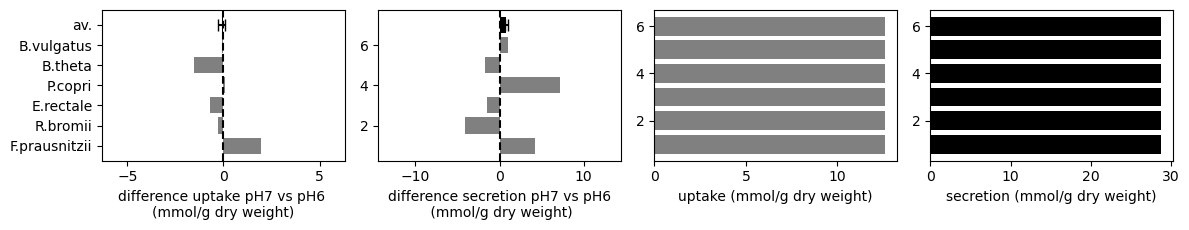

In [11]:
#plot variation panle for main text




#figure for relativve change
fig2, ax2 = plt.subplots(1,4,figsize=(3*4,2.4))  #for barplots yields/excretion
#fig3, ax3 = plt.subplots(num_plots,1,figsize=(3.,1.6*num_plots)) #bar plots of mean and stdev


x=np.linspace(5.3,7.5,10)  
ms='o'
iS=-1



print(specieslist)
specieslist=['B.vulgatus','B.theta','P.copri','E.rectale','R.bromii', 'F.prausnitzii'][::-1]
num_species=len(specieslist)

ratio_uptake=np.zeros([num_species])
ratio_excretion=np.zeros([num_species])
difference_uptake=np.zeros([num_species])
difference_excretion=np.zeros([num_species])

for species in specieslist:
    iS=iS+1
    select2=select.loc[select["species"]==species]
    display(select2)

    if species=="E.rectale":
        print(select2)

    ax[iS,0].set_title(species)
    sc=-1

    first_sec=1
    
    fit_substrates={}
    for sub in sublist:
        sc=sc+1
        ax[iS,0].set_ylim(0,12)
        ax[iS,0].set_xlim(5.3,7.5)
        ax[iS,1].set_xlim(5.3,7.5)
        
        
        if sub in ["glucose"]:
            if species in ['B.vulgatus','B.theta','P.copri','E.rectale']:
                ax[iS,0].plot(select2["pH"],-1*select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
                #totuptake = -1*select2[sub]*cfactorlist[sc]
                fit, covV =np.polyfit(select2["pH"],-1*select2[sub],1,cov=True)
                fit_substrates[sub+"_m"]=fit[0]
                fit_substrates[sub+"_y"]=fit[1]
                fit_substrates[sub+"_m_error"]=covV[0,0]
                ax[iS,0].plot(x,x*fit_substrates[sub+"_m"]+fit_substrates[sub+"_y"],color=colorlist[sc],ls='-')
                fit_substrates["uptake_y"]=fit_substrates[sub+"_y"]
                fit_substrates["uptake_m"]=fit_substrates[sub+"_m"]
                fit_substrates["uptake_m_error"]=covV[0,0]
                   
        elif sub in ["maltose"]:
            if species in ['R.bromii','F.prausnitzii']:
                ax[iS,0].plot(select2["pH"],-2*select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
                #print(select2[sub])
                #if select2[sub]<=0:
                #if select2[sub].isnull().values.any():
                #    pass
                #else:
                #totuptake= -1*select2[sub]*cfactorlist[sc]
                fit, covV =np.polyfit(select2["pH"],-2*select2[sub],1,cov=True)
                fit_substrates[sub+"_m"]=fit[0]
                fit_substrates[sub+"_y"]=fit[1]
                fit_substrates[sub+"_m_error"]=covV[0,0]
                fit_substrates["uptake_y"]=fit_substrates[sub+"_y"]
                fit_substrates["uptake_m"]=fit_substrates[sub+"_m"]
                fit_substrates["uptake_m_error"]=covV[0,0]
              
        else:
            ax[iS,1].plot(select2["pH"],select2[sub],color=colorlist[sc],label=sub,ls='',marker=markerlist[sc])
            if first_sec==1:
                first_sec=0
                totalsecretion=select2[sub].values
            else:
                totalsecretion=totalsecretion+select2[sub].values
            fit, covV =np.polyfit(select2["pH"],select2[sub],1,cov=True)
            fit_substrates[sub+"_m"]=fit[0]
            fit_substrates[sub+"_y"]=fit[1]
            fit_substrates[sub+"_m_error"]=covV[0,0]
                
            if sub=="acetate":
                totfp=select2[sub]*cfactorlist[sc]
            else:
                totfp=totfp+select2[sub]*cfactorlist[sc]
                 

    if species=="E.rectale":    
        print(fit_substrates["uptake_y"])
        print(fit_substrates["uptake_m"])
        
    fit, covV =np.polyfit(select2["pH"],totalsecretion,1,cov=True)
    fit_substrates["tot_secretion_m"]=fit[0]
    fit_substrates["tot_secretion_y"]=fit[1]
    fit_substrates["tot_secretion_m_error"]=covV[0,0]


    #ax[iS,2].plot(select2["pH"],totfp,color="black",label="FP",ls='',marker="o")
    #ax[iS,2].plot(select2["pH"],totuptake,color="gray",label="uptake",ls='',marker="o")
   
    #add relative change to parplot
    pH7val=(fit_substrates["uptake_m"]*7+fit_substrates["uptake_y"])
    ratioc=(fit_substrates["uptake_m"]*6+fit_substrates["uptake_y"])/pH7val
    #calculate error by assuming larger fit
    ratiomax=(pH7val-fit_substrates["uptake_m"]-fit_substrates["uptake_m_error"])/pH7val
    xerr=abs(ratiomax-ratioc)
    #ax2[0].barh(iS+1,ratioc,color='gray',xerr=xerr,capsize=4)
    ratio_uptake[iS]=ratioc
    ax2[2].barh(iS+1,12.61,color='gray') #uptake av
    ax2[3].barh(iS+1,28.82,color='k')  #secretion av

    

    
    #add relative change to parplot
    pH7val=(fit_substrates["tot_secretion_m"]*7+fit_substrates["tot_secretion_y"])
    ratioc=(fit_substrates["tot_secretion_m"]*6+fit_substrates["tot_secretion_y"])/pH7val
    #calculate error by assuming larger fit
    ratiomax=(pH7val-fit_substrates["tot_secretion_m"]-fit_substrates["tot_secretion_m_error"])/pH7val
    xerr=abs(ratiomax-ratioc)
    
    #ax2[1].barh(iS+1,ratioc,color='gray',xerr=xerr,capsize=4)
    ax2[0].barh(iS+1,fit_substrates["uptake_m"],color='gray')
    ax2[1].barh(iS+1,fit_substrates["tot_secretion_m"],color='gray')
    
    difference_uptake[iS]=fit_substrates["uptake_m"]
    ratio_excretion[iS]=ratioc
    difference_excretion[iS]=fit_substrates["tot_secretion_m"]
    print("uptake ")
    print(fit_substrates["uptake_m"])
#add average to bar plots

print("average ratio uptake and excretion")
print(ratio_uptake)
print(ratio_excretion)
print(100*(ratio_uptake-1))
print(100*(ratio_excretion-1))

print("std of ratio")
print(np.std(100*(ratio_uptake-1)))
print(np.std(100*(ratio_excretion-1)))


av_ratio_uptake=np.mean(ratio_uptake)
av_ratio_excretion=np.mean(ratio_excretion)

av_ratio_uptake_relchange=av_ratio_uptake-1.
av_ratio_excretion_relchange=av_ratio_excretion-1.

av_difference_uptake=np.mean(difference_uptake)
av_difference_excretion=np.mean(difference_excretion)
print("average ratio uptake and excre")
print(av_ratio_uptake)
print(av_ratio_excretion)
#print(av_ratio_excretion_relchange)
#print(av_ratio_uptake_relchange)

ax2[0].barh(iS+2,av_difference_uptake,color='k',xerr=np.std(ratio_uptake),capsize=4)
ax2[1].barh(iS+2,av_difference_excretion,color='k',xerr=np.std(ratio_excretion),capsize=4)



#ax4[0].barh(1,av_ratio_uptake_relchange*100,color='k',capsize=4)
#ax4[1].barh(1,av_ratio_excretion_relchange*100,color='k',capsize=4)
#ax4[0].set_xlim(-1,1)
#ax4[1].set_xlim(-1,1)

ax2[0].axvline(0,ls='--',c='k')
ax2[1].axvline(0,ls='--',c='k')

ax2[2].set_xlabel("uptake (mmol/g dry weight)")  
ax2[3].set_xlabel("secretion (mmol/g dry weight)")     

ax2[0].set_xlabel("difference uptake pH7 vs pH6 \n(mmol/g dry weight)")     
ax2[1].set_xlabel("difference secretion pH7 vs pH6\n (mmol/g dry weight)")   

uptakev=12.61/2.
secretionv=28.82/2.
ax2[0].set_xlim(-uptakev,uptakev)
ax2[1].set_xlim(-secretionv,secretionv)

ax2[0].set_yticks(range(1,len(specieslist)+2))
ax2[0].set_yticklabels(specieslist+["av."])

#ax2[0].axvline(1,ls='--',c='k')
#ax2[1].axvline(1,ls='--',c='k')
#ax2[2].axvline(100,ls='--',c='k')
#ax2[3].axvline(100,ls='--',c='k')

fit_substrates["uptake_y"]=fit_substrates[sub+"_y"]
fit_substrates["uptake_m"]=fit_substrates[sub+"_m"]

#sublistshort=['glu','mal','ace','but','for','lac','pro','suc']
#colorlist = met_brewer.met_brew(name="Egypt", n=8, brew_type="continuous")
#sublist=['glucose','maltose','acetate','butyrate','formate','lactate','propionate','succinate'] #skipp ethanol here
#colorlist=['#dd5129', '#85635d', '#2c7591', '#34a28d', '#fab255','#5db27d', '#1e8b99','#acb269']

fig2.tight_layout()
fig2.savefig("plot_output_figure1/pH_dependence_allspecies_for_fig1.pdf")


# Plot pH trends

In [ ]:
# take Richa's data and plot pH trend as an example.



phlist=[5.52,5.97,6.56,7.15]
colorph=["r","b","g","orange"]

strainlist=["P.vulgatus","R.bromii","R.intestinalis"]
markerliststrain=["o","s","v"]
fig, ax = plt.subplots(2,1,figsize=(5*1,3*2))  #for barplots yields/excretion

iS=-1
for strain in strainlist:
    iS=iS+1
    
    pHI = -1
    for ph in phlist:
        pHI = pHI+1
        data=pd.read_csv("data_hplc/example_pHtrend_in_media/pH"+str(ph)+".csv")
        #display(data)
        
        colc=data.columns.tolist().index(strain)
        timec=data.iloc[:,colc-1].values
        #print(timec)
        ODc=data.iloc[:,colc].values
        pHc=data.iloc[:,colc+3].values
        
        #print(pHc)
        #print(ODc)
        ax[0].plot(timec,pHc,label=ph,marker=markerliststrain[iS],ls='',color=colorph[pHI])
        ax[1].plot(ODc,pHc,label=strain,marker=markerliststrain[iS],ls='',color=colorph[pHI])
        
ax[0].legend()
ax[1].legend()
        
ax[0].set_xlabel("time (h)")
ax[0].set_ylabel("pH")

ax[1].set_xlabel("bacterial density (OD)")
ax[1].set_ylabel("pH")
        
fig.tight_layout()
        
## 1. pH versus time and growth curve vs time
## 2. possible end values

# ... old below ...

Plot secretion vs OD curves

In [ ]:

#plot concentration vs OD
####################

print(dataout_av["medium"].unique())
for medium in media:
    print(medium)
    display(dataout_av)
    select=dataout_av.loc[(dataout_av["use_in_study"]=="yes") & (dataout_av["experiment_short"]!="av") &  (dataout_av["medium"]==medium) ]
    display(select)

    select=select.sort_values(by=["strain"])

    strains=select["strain"].unique()
    num_strains=len(strains)

    if num_strains>0:
        fontsize=12
        fig, ax = plt.subplots(num_strains,5,figsize=(5*4,3*num_strains))  #for barplots yields/excretion
        if num_strains==1:
            fig, ax = plt.subplots(2,5,figsize=(5*4,3*2))  #for barplots yields/excretion
        markerlistgr=["8","P","D"]
        linestylegr=["-","--",":"]
        hatch=["//","\\\\","--"]
        iS=-1
        for strain in strains:
            FPvalues=[]
            iS=iS+1
            results=[[],[],[],[],[],[],[],[]]
            select2=select.loc[select["strain"]==strain]
            specieslistcc=select2["species"].tolist()[0]
            print("********** Strain:")
            print(strain)
            gr=[]
            axTW=[]
            #go through all repeats of strains
            iA=-1
            for index,row in select2.iterrows():
                iA=iA+1

                #prepare plot
                if iA<3:
                    axTW.append(ax[iS,iA+2].twinx())
                    if strain in ["DSM17677","ATCC27255"]:
                        ax[iS,iA+2].set_ylabel("$\Delta $ maltose (mM)",fontsize=fontsize,color='#85635d')
                    else:
                        ax[iS,iA+2].set_ylabel("$\Delta $ glucose (mM)",fontsize=fontsize,color='#dd5129')
                    axTW[iA].set_ylabel("$\Delta $ fermentation\n product (mM)",fontsize=fontsize)
                    ax[iS,iA+2].set_xlabel("bacterial density (OD600)",fontsize=fontsize)

                    #plot OD
                    gr.append(row["growth_rate"])

                    try:
                        odcc=row["growthcurve_OD"][1:-1].split(",")
                        timecc=row["growthcurve_time"][1:-1].split(",")
                        print(odcc)
                        print(timecc)
                        odcc=np.array(odcc,dtype=float)
                        timecc=np.array(timecc,dtype=float)

                        odcc = odcc[~np.isnan(timecc)]
                        timecc = timecc[~np.isnan(timecc)]
                        timecc = timecc[~np.isnan(odcc)]
                        odcc = odcc[~np.isnan(odcc)]

                        fitgr=np.polyfit(timecc,np.log(odcc),1)
                        odcc_range=np.linspace(0,np.nanmax(1.1*timecc),50)
                        ax[iS,1].plot(odcc_range,np.exp(odcc_range*fitgr[0]+fitgr[1]),ls=linestylegr[iA],label=iA+1,color="k",lw=1)
                        ax[iS,1].set_yscale("log")
                        ax[iS,1].minorticks_off()
                        ytickod=[0.04,0.08,0.16,0.32,0.64]
                        ax[iS,1].set_yticks(ytickod)
                        ax[iS,1].set_yticklabels(ytickod)
                        ax[iS,1].plot(timecc,odcc,ls='',marker=markerlistgr[iA],color='k',fillstyle="none")
                    except:
                        print("no growth rate data")


                #go through different substrates
                ic=-1
                for sub in sublist:
                    #print(sub)
                    ic=ic+1
                    cfactor=cfactorlist[ic]
                    color=colorlist[ic]
                    label=sublistshort[ic]
                    conversionfactor=1/0.5
                    #print("OD")
                    #print(row[sub+"_OD"])



                    #print(row[sub+"_conc"])
                    if row[sub+"_OD"] in ["nan",np.nan]:
                        pass
                    else:
                        odc=row[sub+"_OD"].replace("[","").replace("]","").replace("  "," ").replace("  "," ").strip().split(" ")
                        concc=row[sub+"_conc"].replace("[","").replace("]","").replace("  "," ").replace("  "," ").strip().split(" ")
                        odc=np.array(odc,dtype=float)
                        concc=np.array(concc,dtype=float)
                        odcval=np.linspace(0,1.1*np.nanmax(odc),10)
                        m=row[sub]
                        y0=row[sub+"_y0"]

                        if sub not in ["glucose","maltose"]:
                            FPvalues.append(np.nanmax(concc)-concc.min())

                        if iA<3:
                            if sub in ["glucose","maltose"]: # and (strain not in ["DSM17677","ATCC27255"]):
                                ax[iS,iA+2].plot(odc,concc-concc.min(),color=color,ls='',marker=markerlist[ic],fillstyle="none")
                                ax[iS,iA+2].plot(odcval,odcval*m+y0-concc.min(),color=color,label=label,ls='--')
                                results[ic].append(-1*m)
                            else:
                                    axTW[iA].plot(odc,concc-concc.min(),color=color,ls='',marker=markerlist[ic],fillstyle="none")
                                    axTW[iA].plot(odcval,odcval*m+y0-concc.min(),color=color,label=label,ls='-')
                                    results[ic].append(m)
                                
                            if ic==0:
                                ax[iS,iA+2].set_title("Replicate "+str(iA+1))


            ax[iS,1].legend(title="replicate")
            print(results)

            iA=-1
            for index,row in select2.iterrows():
                iA=iA+1
                if iA<3:
                    try:
                        axTW[iA].set_ylim(-.2,1.1*max(FPvalues))
                    except:
                        pass
               
            ic=-1
            for sub in sublist:
                #print(sub)
                ic=ic+1
                for iR in [0,1,2]:
                    #print(results)
                    try:
                        ax[iS,0].bar(ic+iR*0.3,results[ic][iR],width=0.25,color=colorlist[ic],hatch=hatch[iR])
                    except:
                        pass

            axGR=ax[iS,0].twinx()
            axGR.set_ylabel("growth rate (1/h)")
            for iR in [0,1,2]:
                    #print(results)
                    try:
                        axGR.bar(9+iR*0.3,gr[iR],width=0.25,color="gray",hatch=hatch[iR],label=iR+1)
                    except:
                        pass
            ax[iS,0].set_xlim(-0.3,10)
            listxt=np.array(range(0,8))+0.3
            ax[iS,0].set_xticks(listxt.tolist()+[9])
            ax[iS,0].set_xticklabels(sublist+["growth\n rate"],rotation=45) # sublistshort
            ax[iS,0].set_ylabel("rate (mM/OD600)")

            axGR.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
                  ncol=3, fancybox=False, shadow=False,title="$"+specieslistcc.replace(".",". ")+"$"+"; replicates")
            ax[iS,1].set_ylabel("bacterial density (OD600)")
            ax[iS,1].set_xlabel("time (h)")

        ax[0,0].legend()
        plt.tight_layout()
        fig.savefig("plot_output_figure1/summary_hplcresults"+medium+".pdf")
        plt.show()

In [ ]:
# Plot scatter plots comparing different media

In [ ]:
display(dataout_av.head())
add_mean=False

#abundance to calculate average rates
abundance_different_strains=[15.5,3,1.9,1.9,0.4,9.2,6.8,2.2,2.1,2.1,9,0.8,0.4,0.2,0.2,1.6][::-1]
abundance_different_strains=np.array(abundance_different_strains)/(sum(abundance_different_strains))


# different media['BHI' 'YCA' 'epsilon plus' 'simple' 'epsilon' 'fecal']
conversionfactor=1/(0.5) #multiply by OD ml/0.5mg to change unti from mM to:   ml mM / mg which is l mM / g which is mmol/g
for cond in [1,3,4,5]:
    
    if cond==1: #plot average values for different strains
        condname="epsilon"
        exp_numberlist=samplenamelist[media.index("epsilon")][::-1]
    #elif cond==2:
    #    condname="fecal"
    #    exp_numberlist=samplenamelist[media.index("fecal")][::-1]
    elif cond==3:
        condname="gamma"
        exp_numberlist=samplenamelist[media.index("gamma")][::-1]
    elif cond==4:
        condname="BHI"
        exp_numberlist=samplenamelist[media.index("BHI")][::-1]
    elif cond==5:
        condname="YCA"
        exp_numberlist=samplenamelist[media.index("YCA")][::-1]
    
    print(condname)
    
    
    datacur=dataout_av.loc[dataout_av["exp_number"].isin(exp_numberlist)]
    datacur=datacur.set_index("exp_number")
    display(datacur)
    
    numexp=datacur.shape[0]
    fig, ax = plt.subplots(1,10,figsize=(35,1+0.5*numexp))  
    ax[0].set_xlabel("uptake (mmol glucose equivalents/g)",fontsize=fontsize)
    ax[1].set_xlabel("excretion (mmol/g)",fontsize=fontsize)
    ax[2].set_xlabel("carbon turnover (mmol/g)",fontsize=fontsize)
    ax[3].set_xlabel("energy yield (kcal/g)",fontsize=fontsize)
    ax[4].set_xlabel("ferm. product (mmol/day)",fontsize=fontsize)
    ax[5].set_xlabel("ferm. product (mmol/day)",fontsize=fontsize)
    ax[6].set_xlabel("energy uptake (kcal/day)",fontsize=fontsize)
    ax[7].set_xlabel("energy uptake (kcal/day)",fontsize=fontsize)
    ax[8].set_xlabel("fraction (%)",fontsize=fontsize)
    ax[9].set_xlabel("fraction (%)",fontsize=fontsize)

    
    for cc in range(0,10):
        ax[cc].set_yticks([-1.5,-0.5]+list(range(1,numexp+1)))
        if add_mean:
            ax[cc].set_ylim(-2,numexp+1)
            if cond==1:
                ax[cc].set_ylim(-3,numexp+3)
        else:
            ax[cc].set_ylim(0.2,numexp+1-0.2)
        straincount=0
    strainl=[]
    strainllabelbar=[]

    consumptionl=[]
    excretionl=[]
    energycontentl=[]
    
                    
    excretion_singlel=np.zeros([len(exp_numberlist),8])
    strainlist2=[]
    iS = -1

    mean_ut=[]
    mean_excretion=[]
    mean_ut_c=[]
    mean_excretion_c=[]
    
    for index in exp_numberlist:
                iS = iS+1
                straincount=straincount+1
                ic = -1
                base=0
                basec=0
                baseut=0
                basecut=0
                energy=0
                
                strainl.append(datacur.at[index,"strain"])
                strainlist2.append(datacur.at[index,"strain"])
                strainllabelbar.append(datacur.at[index,"species"])#+" "+datacur.at[index,"strain"])
                mean_excretion_singlestrain=0
                mean_excretion_singlestrain_c=0
                mean_uptake_singlestrain=0
                mean_uptake_singlestrain_c=0
                consumpc=0
                for sub in sublist:
                    ic=ic+1
                    cfactor=cfactorlist[ic]
                    color=colorlist[ic]
                    if straincount==1:
                        label=sublistshort[ic]
                    else:
                        label=None
                    
                    if sub in ["glucose"]:# and (strainl[-1] not in ["DSM17677","ATCC27255"]):
                        ax[0].barh(straincount,-1*datacur.at[index,sub]*conversionfactor,left=baseut,color=color,label=label,height=0.8)
                        ax[2].barh(straincount+0.2,-1*cfactor*datacur.at[index,sub]*conversionfactor,left=basecut,label=label,color=color,height=0.4,hatch='///')
                        
                        consumpc=consumpc-1*datacur.at[index,sub]*conversionfactor
                        
                        if datacur.at[index,sub]<0:
                            basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            baseut=base-datacur.at[index,sub]*conversionfactor
                        mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    elif sub in ["maltose"]: #and (strainl[-1]  in ["DSM17677","ATCC27255"]):
                        ax[0].barh(straincount,-2*datacur.at[index,sub]*conversionfactor,left=baseut,color=color,label=label,height=0.8)
                        ax[2].barh(straincount+0.2,-1*cfactor*datacur.at[index,sub]*conversionfactor,left=basecut,label=label,color=color,height=0.4,hatch='///')
                        consumpc=consumpc-2*datacur.at[index,sub]*conversionfactor
                        mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        
                        if datacur.at[index,sub]<0:
                            basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            baseut=base-datacur.at[index,sub]*conversionfactor
                        
                        inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    
                    else:# datacur.at[index,sub]>0.5: #for other fermentation products, require more than 0.5
                        ax[1].barh(straincount,datacur.at[index,sub]*conversionfactor,left=base,color=color,label=label,height=0.8)
                        ax[2].barh(straincount-0.2,cfactor*datacur.at[index,sub]*conversionfactor,left=basec,color=color,label=label,height=0.4,hatch='\\\\\ ')
                        
                        basec=basec+cfactor*datacur.at[index,sub]*conversionfactor
                        base=base+datacur.at[index,sub]*conversionfactor
                        energy=energy+datacur.at[index,sub]*conversionfactor*energycontent[ic] #unit mmol/g *energycontent (unit kcal/mmol)
                        excretion_singlel[iS,ic] = datacur.at[index,sub]*conversionfactor
                        if datacur.at[index,sub]>0:
                            mean_excretion_singlestrain=mean_excretion_singlestrain+datacur.at[index,sub]*conversionfactor
                            mean_excretion_singlestrain_c=mean_excretion_singlestrain_c+datacur.at[index,sub]*conversionfactor*cfactor
                consumptionl.append(consumpc)
                ax[0].errorbar(conversionfactor*datacur.at[index,"total_uptake"]*(-1),straincount,xerr=conversionfactor*datacur.at[index,"total_uptake_std"],color='k',capsize=10, elinewidth=2)
                ax[1].errorbar(conversionfactor*datacur.at[index,"total_ferm"],straincount,xerr=conversionfactor*datacur.at[index,"total_ferm_std"],color='k', capsize=10, elinewidth=2)
                mean_excretion.append(mean_excretion_singlestrain) 
                mean_excretion_c.append(mean_excretion_singlestrain_c)    
                mean_ut.append(mean_uptake_singlestrain)
                mean_ut_c.append(mean_uptake_singlestrain_c)
                       
                excretionl.append(base)
                energycontentl.append(energy)
                #energy content
                ax[3].barh(straincount,energy,left=0,color='gray',label=label,height=0.8)
                
                #bacterial drymass
                bactmass_ref=16.18 #for British ref diet g/day
                carbin_ref=44.6 #fro British ref diet g/day
                ax[4].set_title("ref diet - from feces")
                ax[4].barh(straincount,base*bactmass_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                ax[5].set_title("ref diet - from tot. carb.")
                ax[5].barh(straincount,base*carbin_ref/inverseyield,left=0,color='gray',label=label,height=0.8) #mmol/day
                
                ax[6].set_title("ref diet - from glucose")
                ax[6].barh(straincount,energy*bactmass_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                ax[7].set_title("ref diet - from tot. carb.")
                ax[7].barh(straincount,energy*carbin_ref/inverseyield,left=0,color='gray',label=label,height=0.8) #mmol/day
                
                totalcen_ref=2275.0 #kcal/day for british ref diet
                ax[8].set_title("ref diet - from feces")
                ax[8].barh(straincount,100*energy*bactmass_ref/totalcen_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                ax[9].set_title("ref diet - from tot. carb.")
                ax[9].barh(straincount,100*energy*carbin_ref/inverseyield/totalcen_ref,left=0,color='gray',label=label,height=0.8) #mmol/day
                
                           
                
    if add_mean:
        print(mean_excretion)
        print(mean_excretion_c)
        ax[0].barh(-0.5,np.average(mean_ut),left=0,color='dimgray',label=label,height=0.8) #mmol/day
        ax[1].barh(-0.5,np.average(mean_excretion),left=0,color='silver',label=label,height=0.8) #mmol/day
        ax[2].barh(-0.5+0.2,np.average(mean_ut_c),left=0,label="mean",color='dimgray',height=0.4,hatch='///')
        ax[2].barh(-0.5-0.2,np.average(mean_excretion_c),left=0,label="mean",color='silver',height=0.4,hatch='\\\\\ ')
    
        abundance_different_strains=np.array(abundance_different_strains)
        mean_ut=np.array(mean_ut)
        mean_excretion=np.array(mean_excretion)
        mean_ut_c=np.array(mean_ut_c)
        mean_excretion_c=np.array(mean_excretion_c)
        
        ax[0].barh(-1.5,np.sum(np.multiply(abundance_different_strains,mean_ut)),left=0,color='dimgray',label=label,height=0.8) #mmol/day
        ax[1].barh(-1.5,np.sum(np.multiply(abundance_different_strains,mean_excretion)),left=0,color='silver',label=label,height=0.8) #mmol/day
        ax[2].barh(-1.5+0.2,np.sum(np.multiply(abundance_different_strains,mean_ut_c)),left=0,label="mean",color='dimgray',height=0.4,hatch='///')
        ax[2].barh(-1.5-0.2,np.sum(np.multiply(abundance_different_strains,mean_excretion_c)),left=0,label="mean",color='silver',height=0.4,hatch='\\\\\ ')
        
        print("average secretion")
        print(np.sum(np.multiply(abundance_different_strains,mean_excretion)))
        
    excretion_singlel=pd.DataFrame(excretion_singlel,columns=sublist).iloc[::-1]
    excretion_singlel.index=strainlist2[::-1]
    
    excretionl=np.array(excretionl[::-1])
    consumptionl=np.array(consumptionl[::-1])
    energycontentl=np.array(energycontentl[::-1])
    
    if 2>4: #cond==1:
        #add reference condition
        base2=0
        basec2=0
        base2ut=0
        basec2ut=0
        energy2=0
        ic = -1
        for sub in sublist:
            ic = ic+1
            cfactor=cfactorlist[ic]
            color=colorlist[ic]
            
            if sub in ['glucose','maltose']:
                ax[0].barh(straincount+1,ref_values[sub],left=base2ut,color='k',height=0.8)
                ax[2].barh(straincount+1-0.2,cfactor*ref_values[sub],left=basec2ut,label=label,color=color,height=0.4,hatch='///')
                basec2ut=basec2ut+cfactor*ref_values[sub]
                base2ut=base2ut+ref_values[sub]
               
            else:
                ax[1].barh(straincount+1,ref_values[sub],left=base2,color=color,label=label,height=0.8)
                ax[2].barh(straincount+1+0.2,cfactor*ref_values[sub],left=basec2,label=label,color=color,height=0.4,hatch='\\\\\ ')
                
                basec2=basec2+cfactor*ref_values[sub]
                base2=base2+ref_values[sub]
                energy2=energy2+ref_values[sub]*energycontent[ic] #unit mmol/g *energycontent (unit kcal/mmol)
        ax[3].barh(straincount+1,energy2,left=0,color='k',label=label,height=0.8)
        
        ax[4].barh(straincount+1,base2*bactmass_ref,left=0,color='k',label=label,height=0.8) #mmol/day
        ax[5].barh(straincount+1,base2*carbin_ref/inverseyield,left=0,color='k',label=label,height=0.8) #mmol/day
                
        ax[6].barh(straincount+1,energy2*bactmass_ref,left=0,color='k',label=label,height=0.8) #mmol/day
        ax[7].barh(straincount+1,energy2*carbin_ref/inverseyield,left=0,color='k',label=label,height=0.8) #mmol/day
                
        ax[8].barh(straincount+1,100*energy2*bactmass_ref/totalcen_ref,left=0,color='k',label=label,height=0.8) #mmol/day
        ax[9].barh(straincount+1,100*energy2*carbin_ref/inverseyield/totalcen_ref,left=0,color='k',label=label,height=0.8) #mmol/day
    
    ax[0].axvline(consumptionl[:].mean(),ls='--',color='k')
    
    ax[1].axvline(excretionl[:].mean(),ls='--',color='k')
          
    ax[3].axvline(energycontentl[:].mean(),ls='--',color='k')
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=14)
    print(len(strainllabelbar))
    ax[0].set_yticklabels(["weighted by\n abundance","average"]+strainllabelbar,fontsize=fontsize)
    plt.tight_layout()
    fig.savefig("plot_output_figure1/barplots_"+condname+".pdf")
    plt.show()

# Fermentation products - scattering

In [ ]:
# different media['BHI' 'YCA' 'epsilon plus' 'simple' 'epsilon' 'fecal']
conversionfactor=1/(0.5) #multiply by OD ml/0.5mg to change unti from mM to:   ml mM / mg which is l mM / g which is mmol/g

num_plots=4 #uptake, secetion, different SCFA
fig, ax = plt.subplots(1,num_plots,figsize=(4*num_plots,2.5))
fig2, ax2 = plt.subplots(1,num_plots,figsize=(4*num_plots,2.5)) #bar plots of mean and stdev
fig3, ax3 = plt.subplots(num_plots,1,figsize=(3.,2.4*num_plots)) #bar plots of mean and stdev


conditionlist=[1,2,3,4]
xticklabels=[]
xticks=conditionlist

for cond in conditionlist:
    
    if cond==3: #plot average values for different strains
        
        condname="epsilon"
        exp_numberlist=samplenamelist[media.index("epsilon")][::-1]
    elif cond==4:
        condname="gamma"
        exp_numberlist=samplenamelist[media.index("gamma")][::-1]
    elif cond==2:
        condname="BHI"
        exp_numberlist=samplenamelist[media.index("BHI")][::-1]
    elif cond==1:
        condname="YCA"
        exp_numberlist=samplenamelist[media.index("YCA")][::-1]
    else:
        error
        
    # different media['BHI' 'YCA' 'epsilon plus' 'simple' 'epsilon' 'fecal']
    
    
    xticklabels.append(condname)
    print(condname)
    
    
    datacur=dataout_av.loc[dataout_av["exp_number"].isin(exp_numberlist)]
    datacur=datacur.set_index("exp_number")
    display(datacur)
    
    fontsize=14
    numexp=datacur.shape[0]
    
    
    
    
    strainl=[]
    strainllabelbar=[]
    consumptionl=[]
    excretionl=[]
    energycontentl=[]
    
                    
    excretion_singlel=np.zeros([len(exp_numberlist),8])
    strainlist2=[]
    iS = -1

    mean_ut=[]
    mean_excretion=[]
    mean_ut_c=[]
    mean_excretion_c=[]
    
    for index in exp_numberlist:
                iS = iS+1
                
                straincount=straincount+1
                
                ic = -1
                base=0
                basec=0
                baseut=0
                basecut=0
                energy=0
                
                strainl.append(datacur.at[index,"strain"])
                strainlist2.append(datacur.at[index,"strain"])
                strainllabelbar.append(datacur.at[index,"species"])#+" "+datacur.at[index,"strain"])
                mean_excretion_singlestrain=0
                mean_excretion_singlestrain_c=0
                mean_uptake_singlestrain=0
                mean_uptake_singlestrain_c=0
                consumpc=0
                for sub in sublist:
                    ic=ic+1
                    cfactor=cfactorlist[ic]
                    color=colorlist[ic]
                    if straincount==1:
                        label=sublistshort[ic]
                    else:
                        label=None
                    
                    if sub in ["glucose"]:# and (strainl[-1] not in ["DSM17677","ATCC27255"]):
                        consumpc=consumpc-1*datacur.at[index,sub]*conversionfactor
                        
                        if datacur.at[index,sub]<0:
                            basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            baseut=base-datacur.at[index,sub]*conversionfactor
                        mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    elif sub in ["maltose"]: #and (strainl[-1]  in ["DSM17677","ATCC27255"]):
                        consumpc=consumpc-2*datacur.at[index,sub]*conversionfactor
                        
                        mean_uptake_singlestrain=mean_uptake_singlestrain-conversionfactor*datacur.at[index,sub]
                        mean_uptake_singlestrain_c=mean_uptake_singlestrain_c-cfactor*conversionfactor*datacur.at[index,sub]
               
                        if datacur.at[index,sub]<0:
                            basecut=basec-cfactor*datacur.at[index,sub]*conversionfactor
                            baseut=base-datacur.at[index,sub]*conversionfactor
                        
                        inverseyield=-1*baseut*0.18 #mmol/g bacteria *0.18 g glucose /mmol -> gram glucose/gram bacter
                        excretion_singlel[iS,ic] = -1*datacur.at[index,sub]*conversionfactor
                    
                    
                    else:# datacur.at[index,sub]>0.5: #for other fermentation products, require more than 0.5
                        
                        basec=basec+cfactor*datacur.at[index,sub]*conversionfactor
                        base=base+datacur.at[index,sub]*conversionfactor
                        energy=energy+datacur.at[index,sub]*conversionfactor*energycontent[ic] #unit mmol/g *energycontent (unit kcal/mmol)
                        excretion_singlel[iS,ic] = datacur.at[index,sub]*conversionfactor
                        if datacur.at[index,sub]>0:
                            mean_excretion_singlestrain=mean_excretion_singlestrain+datacur.at[index,sub]*conversionfactor
                            mean_excretion_singlestrain_c=mean_excretion_singlestrain_c+datacur.at[index,sub]*conversionfactor*cfactor
                consumptionl.append(consumpc)
                mean_excretion.append(mean_excretion_singlestrain) 
                mean_excretion_c.append(mean_excretion_singlestrain_c)    


    
    consumptionl=np.array(consumptionl)
    mean_excretion=np.array(mean_excretion)
    mean_excretion_c=np.array(mean_excretion_c)
    ax[0].scatter(consumptionl*0+cond,consumptionl)
    ax[1].scatter(consumptionl*0+cond,mean_excretion)
    ax[2].scatter(consumptionl*0+cond,np.array(consumptionl)*6) #carbon content
    ax[3].scatter(consumptionl*0+cond,mean_excretion_c)
    
    ax2[0].bar(cond,np.nanmean(consumptionl),yerr=np.nanstd(consumptionl),color='gray')
    ax2[1].bar(cond,np.nanmean(mean_excretion),yerr=np.nanstd(mean_excretion),color='gray')
    ax2[2].bar(cond,np.nanmean(consumptionl)*6,width=0.35,yerr=np.nanstd(consumptionl)*6,color='gray')
    ax2[2].bar(cond+0.4,np.nanmean(mean_excretion_c),width=0.35,yerr=np.nanstd(mean_excretion_c),color='gray')
    
    cond2=5-cond
    hatchconsumption="//"
    hatchexcretion="\\\\"
    colorbar='grey'
    cs=7
    
    cs2=4
    ax3[0].barh(cond2,np.nanmean(consumptionl),xerr=np.nanstd(consumptionl),color=colorbar,capsize=cs)#,hatch=hatchconsumption)
    ax3[1].barh(cond2,np.nanmean(mean_excretion),xerr=np.nanstd(mean_excretion),color=colorbar,capsize=cs)#,hatch=hatchexcretion)
    ax3[2].barh(cond2+0.4,np.nanmean(consumptionl)*6,height=0.35,xerr=np.nanstd(consumptionl)*6,color=colorbar,hatch=hatchconsumption,capsize=cs2)
    ax3[2].barh(cond2,np.nanmean(mean_excretion_c),height=0.35,xerr=np.nanstd(mean_excretion_c),color=colorbar,hatch=hatchexcretion,capsize=cs2)
    for i in [0,1,2]:
        ax3[i].set_yticks([1,2,3,4])
        ax3[i].set_yticklabels(["$\gamma$","$\epsilon$","BHI","YCA"])
        ax3[i].set_ylabel("medium")
    ax3[0].set_xlabel("consumption (mmol/g)")
    ax3[1].set_xlabel("excretion (mmol/g)")
    ax3[2].set_xlabel("carbon turnover (mmol/g)")
  
for i in range(0,num_plots):
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xticklabels)

ax[0].set_ylabel("uptake")
ax[1].set_ylabel("excretion")
ax[2].set_ylabel("carbon uptake")
ax[3].set_ylabel("carbon excretion")


plt.tight_layout()
fig.savefig("plot_output_figure1/different_media.pdf")
fig3.savefig("plot_output_figure1/different_media_hbar.pdf")
plt.show()